###  Islands: Generalized Linear Models - Chapter 3

[Back to Main Page](0_main_page.ipynb)

<br>

<h1> <center> Poisson Regression </center> </h1>  

<br>
<center><img src = "images/island_pois_reg.png" width = 270></center>

Imagine you are visiting a new island, this time with a team of biologists. You are here to study a particular species of omnivourous animal. You're investigating the hypothesis that changes in the level of a particular hormone predict the number of predation events carried out by the animal. 

You collect data across a one-week period, on 3 variables:

`hormone_level_change`:  a continuous numerical variable, the change in the hormone levels in the blood, from the start of the week to the end

`biological_sex`: a binary nominal-categorical variable, the biological sex of the animal

`number_of_predation_events`: a discrete numerical variable, the number of predation events carried out by the animal

The data your team has collected is shown in the output of the cell below. The dataframe contains the data for 100 randomly sampled animals:

In [1]:
# importing the libraries needed for this page
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.special import factorial
from scipy.optimize import minimize
import islands_GLM
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# make plots look like R
islands_GLM.r_ify()

# generate the data
df = islands_GLM.generate_poisson_data()

# show the data
df

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


,hormone_level_change,biological_sex,number_of_predation_events
0,-139.98,1,0
1,27.41,1,11
2,92.24,1,13
3,-20.19,0,6
4,78.51,1,12
...,...,...,...
95,0.24,0,3
96,-6.08,1,8
97,0.32,1,6
98,-14.80,1,6


The statistical model your team is testing first is: `number_of_predation_events ~ hormone_level_change`

...or equivalently, that "the `number_of_predation_events` events can be predicted as a function of `hormone_level_change`".

Notably, `number_of_predation_events` is a *count* variable - it cannot take negative values (a negative number of predation events is nonsensical), and it occurs only in whole number values (we can't have half a predation event, or 65.685937493 predation events, for one animal).

The histogram of `number_of_predation_events` is shown below:

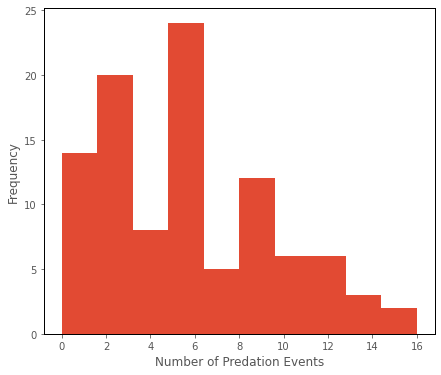

In [2]:
# this code generates the plot below
islands_GLM.count_hist(df);

Because we're interested in whether changes in the hormone level are associated with increased number of predation events, let's inspect a scatterplot with `hormone_level_change` on the x-axis and `number_of_predation_events` on the y-axis:

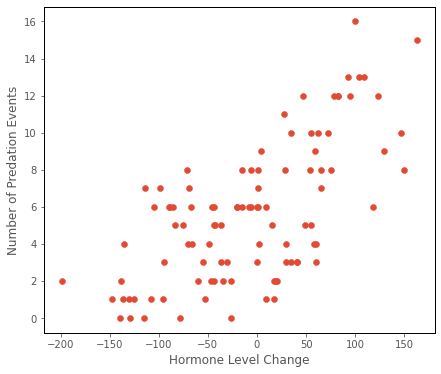

In [3]:
# this code generates the plot below
islands_GLM.hormone_predation_plot(df);

It might look reasonable, from the trend on the scatterplot, to apply the tools from the [Linear Regression page](2_linear_regression.ipynb) here.

The output of the cell below shows the results of fitting a linear regression model (`number_of_predation_events ~ hormone_level_change`) to this data:

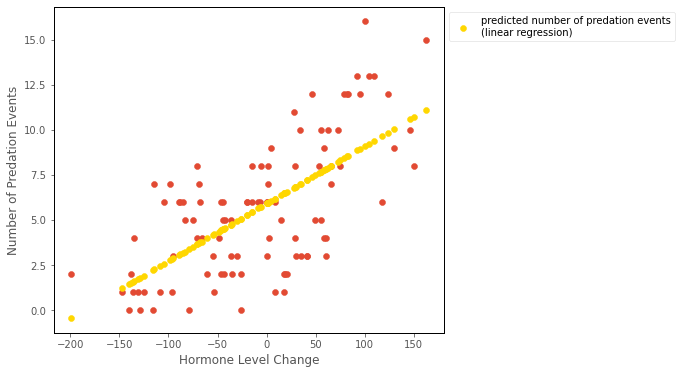

In [4]:
# fit a linear regression model and plot the predictions
lin_reg = smf.ols('number_of_predation_events ~ hormone_level_change', data = df).fit()
lin_reg_predictions = lin_reg.params[0] + lin_reg.params[1] * df['hormone_level_change']
islands_GLM.hormone_predation_plot(df, with_predictions = True, predictions = lin_reg_predictions);

That looks like it fits the data OK, but there is a problem. If you look at the prediction for at -200 on the x-axis, it is negative. The prediction is computed in the cell below, from the linear regression parameters:

In [5]:
# nonsensical predictions
lin_reg.params[0] + lin_reg.params[1] * -200

-0.4727070243375424

This prediction is nonsense for a count outcome variable like `number_of_predation_events`, and is a problem for using linear regression with count data, when a lot of the values fall close to 0.

Fortunately, there are several several generalized linear models for count data. We will look at the most foundational one: Poisson regression.

## Context

Poisson regression  is a generalized linear model used to model the relationship between a count outcome variable (that can take only positive integer values) and one or more predictor variables. As with all generalized linear models, the predictor variables can be of any type (quantitative-continuous, quantitative-discrete, nominal-categorical, ordinal-categorical). The predictions from Poisson regression can range from zero to positive infinity. 

Poisson regression that involves fitting a set of Poisson distributions to the outcome variable, where the means of the Poisson distributions vary as a function of the predictor(s). The Poisson distribtion is a distributional form which describes count variables. The python cell below creates a graph which shows the Poisson distribution with a mean of 1:

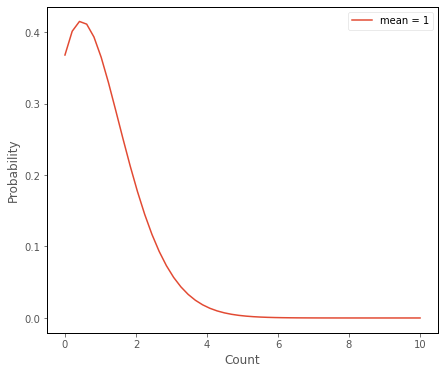

In [6]:
# this code generates the plot below
islands_GLM.poisson_plot([1], 10)

Here are several Poisson distributions, with different means:

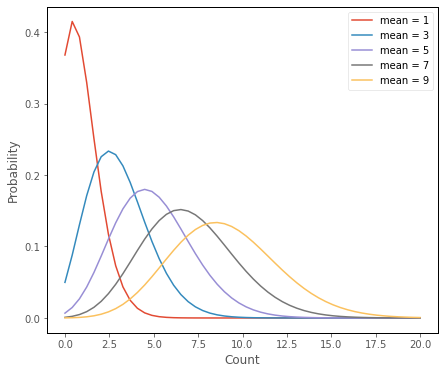

In [7]:
# this code generates the plot below
islands_GLM.poisson_plot(np.arange(1, 11, step = 2), 20)

We can see that the Poisson distribution gets more like a normal as the mean increases. Where linear regression fits a set of normal distributions to the data, Poisson regression fits a set of Poisson distributions, as shown in the figures below:

![](images/poiss_reg.png)
(image from https://stats.stackexchange.com/questions/542155/how-the-poisson-distribution-is-used-in-regression)

(The graph below shows linear regression - fitting normal distributions - on the left, and Poisson regression - fitting Poisson distributions, on the right):

![](images/poiss_reg_2.png)
(image from https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html)

## Model

Remember from the [What are generalized linear models?](1_generalized_linear_models.ipynb) page that generalized linear models predict some function of the mean as a function of the linear prediction equation.

In the case of linear regression, this function of the mean is just $1 * \mu$. For other generalized liner models, like Poisson regression, we use a different function of the mean.

In effect, using the linear prediction equation to predict a function of the mean (other than the identity link function used in linear regression) this fits a line on some scale other than the scale of the original data. E.g. it fits a line on whatever scale the transformation of the mean is on.

Poisson regression uses a logarithmic link function - it fits a line on the log scale, and is sometimes referred to as a loglinear model. The prediction equation for Poisson regression is:

$ \Large ln(\hat{y_{i}}) = b_{0} + b_{1}x_{1i} + ... b_{k}x_{ki}  $

Obviously, we aren't really interested in the log scale, we're interested in the original scale of the data, so we have to exponeniate the right hand side of the model to get predictions on the original scale:

$ \Large \hat{y_{i}} = e^{(b_{0} + b_{1}x_{1i} + ... b_{k}x_{ki})}  $

where:

$\hat{y_i} $ : is the predicted value of the outcome variable for a given set of predictor scores, for the $i$th observation

$b_0$ : is the intercept term, the predicted value of the outcome variable when all predictors equal 0

$b_1$ : is the slope of the 1st predictor variable

$x_{1i}$ : is the score on the the first predictor variable, for the $i$th observation

$b_k$ : is the slope of the $k$th predictor variable

$x_{ki}$ : is the score on the $k$th predictor variable, for the $i$th observation


The individual Poisson regression predictions ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \Large ln(\hat{y_{1}}) = b_{0} + b_{1}x_{11} + ... b_{k}x_{k1} $$

$$ \Large ln(\hat{y_{2}}) = b_{0} + b_{1}x_{12} + ... b_{k}x_{k2}  $$

$$ \Large ln(\hat{y_{3}}) = b_{0} + b_{1}x_{13} + ... b_{k}x_{k3}  $$

$$ \dots $$

$$ \Large ln(\hat{y_{n}}) = b_{0} + b_{1}x_{1n} + ... b_{k}x_{kn}  $$


In matrix form the Poisson regression model is:

$$
\Large \begin{bmatrix}
           {ln(\hat{y}_{1})} \\
           \vdots \\
           {ln(\hat{y}_{n})}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$




## Parameter Estimation

The parameter estimates are obtained by maximizing the likelihood function (where $\hat{y_{i}} = e^{(b_{0} + b_{1}x_{1i} + ... b_{k}x_{ki})}$):

$ \Huge \prod\limits_{i = 1}^{n} \frac{\hat{y}^{y_i}_i e^{-\hat{y_i}}}{y_i!}$

This formula is dervied from the probability mass function for Poisson distribution. The mean of the Poisson distribution is $\hat{y_i}$ (this is the only parameter upon which the shape of the Poisson distribution depends). For a given value of $\hat{y_i}$, the probability mass formula computes the probability of randomly sampling a particular observation $y_i$ from a Poisson distribution with that particular mean. The python cell below defines a function which implements the formula, aside from the product operator (so it returns a vector of probabilities, rather than the product of the probabilities): 

In [8]:
# a function to implement the PMF of the Poisson distribution
def poisson_func(lambd, x):
  
    return (lambd**x * np.exp(-lambd))/factorial(x)

The cell below uses this formula to plot a Poisson distribution with a mean of 1, where the input values to the function range from 0 to 15 (remember that the Poisson distribution cannot take negative values):

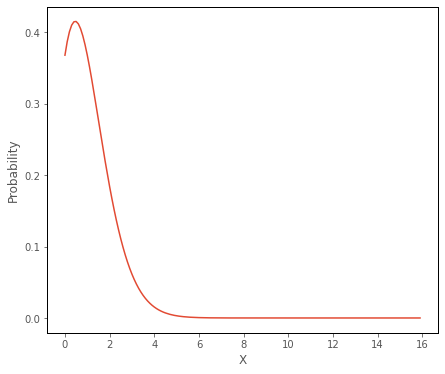

In [9]:
# this code generates the plot below
plt.plot(np.arange(0, 16, 0.1), poisson_func(1, np.arange(0, 16, 0.1)))
plt.xlabel('X')
plt.ylabel('Probability');

The cell below uses this formula to plot a Poisson distribution with a mean of 4, where the input values to the function range from 0 to 15:

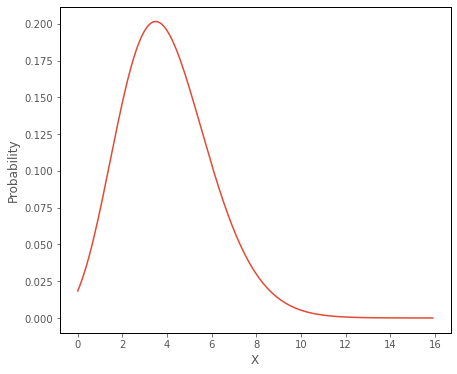

In [10]:
# this code generates the plot below
plt.plot(np.arange(0, 16, 0.1), poisson_func(4, np.arange(0, 16, 0.1)))
plt.xlabel('X')
plt.ylabel('Probability');

The likelihood function for Poisson regression takes the dataset (the predictor scores and outcome scores), and one parameter vector ($\hat{y_i}$) and computes the likelihood of obtaining the outcome scores, conditional on the predictor scores and the values in the parameter vector. The parameter vector $\hat{y_i}$ contains the predictions obtained from the linear prediction equation $b_0 + b_1x_{1i} ... + b_kx_{ki} $. 

By finding the values of of $b_0$,  $b_k$ and $\sigma$ which maximize the likelihood function shown above, we find the set of Poisson distributions which best fit the data, as shown in the image above. The formula is called the *maximum likelihood* formula, and using it yields the maximum likelihood estimates of the intercept and slopes. These intercept and slopes will yield a straight line if the data is log-transformed.

As with linear regression, because maximizing the likelihood formula involves multiplying together probabilities, the numbers involved are so small it can lead to computational errors. In practice, again we minimize the *negative log-likelihood*, rather than directly maximizing the likelihood. This produces the same parameter estimates, but is less prone to numerical errors. The negative log-likelihood formula is: 

$ \Huge - \sum\limits_{i = 1}^{n} {y_i} ln(\hat{y}) -\hat{y_i} -ln(y_i!) $ 

This formula is just the result of applying the log transformation to the likelihood formula shown earlier (and multiplying it by -1).

## Implementation

The cell below defines a function which implements the negative log-likelihood formula:

In [11]:
# the cost function for Poisson regression
def neg_log_like_pois(intercept_slope, predictor, outcome):
  
  intercept, slope = intercept_slope[0], intercept_slope[1]
  
  predicted = np.exp(intercept + slope * predictor)
  
  neg_log_like = outcome * np.log(predicted) - predicted - np.log(factorial(outcome))
  
  return -np.sum(neg_log_like)

The python cell below tests the the negative log likelihood function with the parameters: 

$b_0$ = 0

$b_1$ = 0

for the `number_of_predation_events ~ hormone_level_change` data:

In [12]:
# test the cost function, with intercept = 0 and slope = 0
neg_log_like_pois([0,0], df['hormone_level_change'], df['number_of_predation_events'])

809.489446579875

Again we can pass this function and the initially guessed parameters, to the [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function, from the [SciPy](https://scipy.org/) library.

This function will try various sets of parameters until it finds the parameters which give the lowest value of the function. This is carried out in the cell below:

In [13]:
# find the parameters which minimize the cost function
pois_reg_minimize = minimize(neg_log_like_pois, [0.4, 0.017], args = (df['hormone_level_change'], df['number_of_predation_events']))
pois_reg_minimize.x

array([1.67842089, 0.00579493])

The values in the array above are (in order) the intercept and slope values which give the lowest negative loglikelihood, and are the parameters which give the set of Poisson distributions which best fit the data:

![](images/poiss_reg.png)
(image from https://stats.stackexchange.com/questions/542155/how-the-poisson-distribution-is-used-in-regression)

The predictions from the Poisson regression are shown on the scatterplot below:

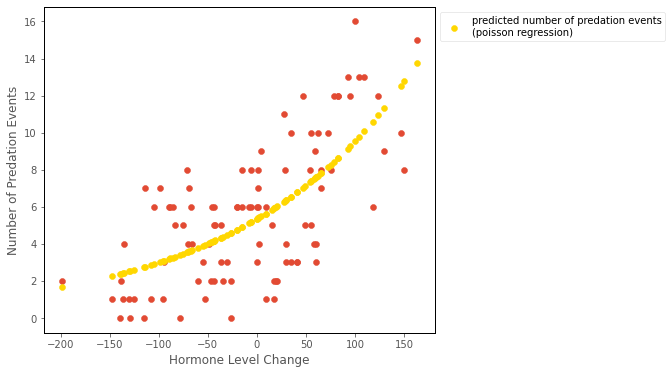

In [14]:
# this code generates the plot below
intercept, slope = pois_reg_minimize.x
islands_GLM.hormone_predation_plot(df, with_predictions = True, predictions = np.exp(intercept + slope * df['hormone_level_change']),
                                  model_name = 'poisson regression');

We can see that they fit the curved trend of the data better than the liner regression did. And they also will not produce nonsensical negative predictions:

In [15]:
# sensical predictions!
np.exp(intercept + slope * - 200)

1.6810760145251222

We get the same parameters and predictions if we use the Poisson regression model from the [statsmodels](https://www.statsmodels.org/stable/index.html) library:

In [16]:
# fit a Poissin regression model using the statsmodels library
pois_mod = smf.glm('number_of_predation_events ~ hormone_level_change', data =df, family = sm.families.Poisson()).fit()

# show the regression table
pois_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     number_of_predation_events   No. Observations:                  100
Model:                                    GLM   Df Residuals:                       98
Model Family:                         Poisson   Df Model:                            1
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -242.86
Date:                        Fri, 01 Jul 2022   Deviance:                       159.05
Time:                                10:40:17   Pearson chi2:                     140.
No. Iterations:                             4                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.6784      0.045     37.705      0.000       1.591       1.766
hormone_level_change     0.0058      0.001     10.313      0.000       0.005       0.007
========================================================================================
"""

## Interpretation (one predictor model)

The parameter estimates tell us:

$b_0$ : the intercept, the expected value of the outcome,  on a log scale, for an observation where the predictor equals 0.

$b_1$: the predicted change in the outcome variable, on a log scale, for a 1-unit increase in the predictor.

The parameters, without transformation, refer to the log scale, on which the Poisson regression model fits a straight line:

$ \Large ln(\hat{y_{i}}) = b_{0} + b_{1}x_{1i} + ... b_{k}x_{ki}  $

The predictions, on the log scale, are shown on the graph below:

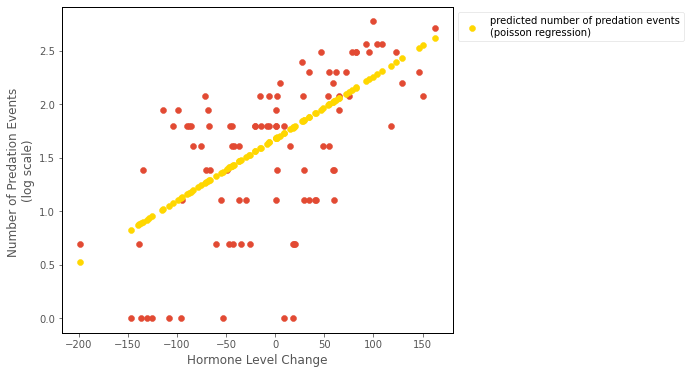

In [17]:
# this code generates the plot below
np.seterr(invalid='ignore')
np.seterr(divide = 'ignore')
islands_GLM.hormone_predation_plot(df, with_predictions = True, predictions = intercept + slope * df['hormone_level_change'],
                                  model_name = 'poisson regression', log_scale = True)

To get the predictions on the original scale we have to exponeniate them:

$ \Large \hat{y_{i}} = e^{(b_{0} + b_{1}x_{1i} + ... b_{k}x_{ki})}  $

The predictions, on the original scale, are shown on the graph below:

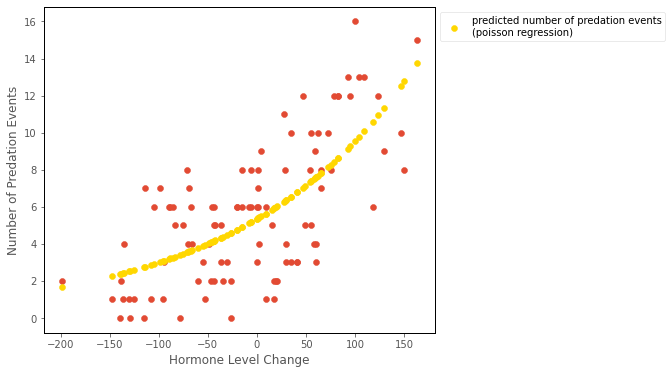

In [18]:
# this code generates the plot below
islands_GLM.hormone_predation_plot(df, with_predictions = True, predictions = np.exp(intercept + slope * df['hormone_level_change']),
                                  model_name = 'poisson regression')

## Effect of the slope and intercept on the Poisson Regression curve

On the log scale, changing the intercept moves the prediction line up and down the y-axis. On the original scale, changing the intercept moves the poisson regression curve up and down the y-axis:

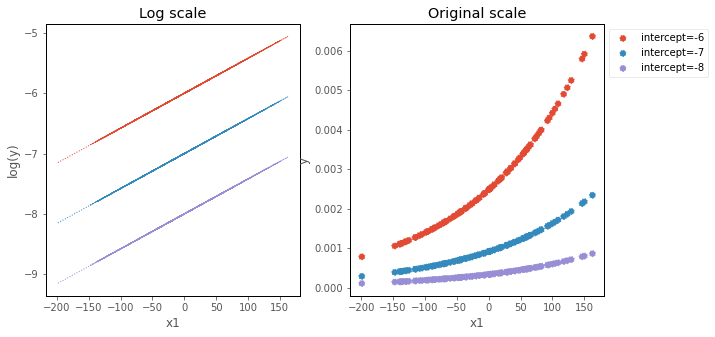

In [19]:
# this code generates the plots below
b0 = pois_mod.params[0]
b1 = pois_mod.params[1]
islands_GLM.odds_original_intercept_plot(b0, b1, df);

Changingt the slope changes the steepness of the line/curve, on each scale:

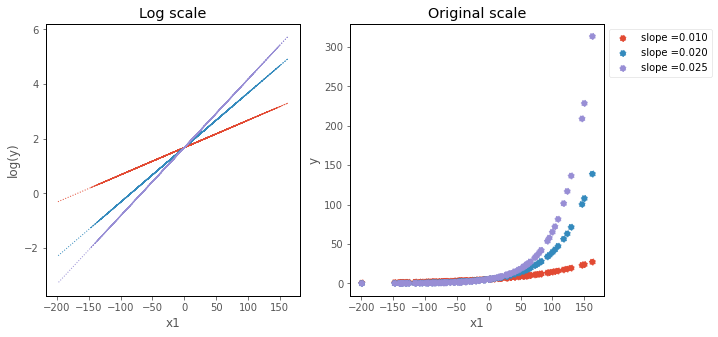

In [20]:
# this code generates the plots below
islands_GLM.odds_original_slope_plot(b0, b1, df);

## Poisson Regression with multiple predictors

For models with more than one predictor, Poisson regression fits a surface to the data if there are two predictors, and a manifold if there are more than two (higher dimensional models are hard/impossible to visualize, but are generalizations of the 3D case).

The graph below shows a Poisson regression model fit to an outcome with two continuous predictor variables. The blue surface is the Poisson regression model, the red dots are the hypothetical data points. The blue surface indicates the predicted outcome scores, for any pair of scores on the predictor variables:

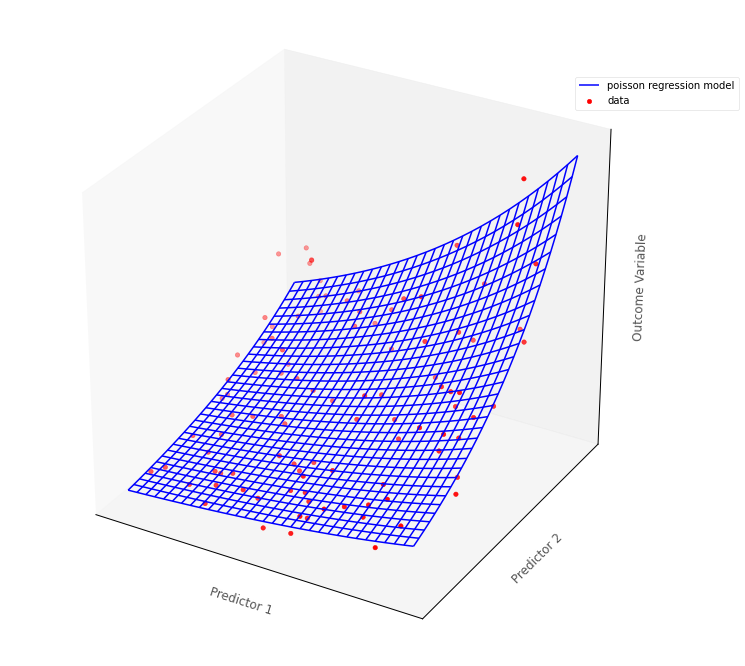

In [21]:
# show how poisson regression works in multiple dimensions
islands_GLM.three_D_pois_reg_plot()

Recall that the data from the island consists of three variables:

`hormone_level_change`:  a continuous numerical variable, the change in the hormone levels in the blood, from the start of the week to the end

`biological_sex`: a binary nominal-categorical variable, the biological sex of the animal

`number_of_predation_events`: a discrete numerical variable, the number of predation events carried out by the animal

In [22]:
# show the dataframe
df

,hormone_level_change,biological_sex,number_of_predation_events
0,-139.98,1,0
1,27.41,1,11
2,92.24,1,13
3,-20.19,0,6
4,78.51,1,12
...,...,...,...
95,0.24,0,3
96,-6.08,1,8
97,0.32,1,6
98,-14.80,1,6


Your team is also interested in investigating the influence of `hormone_level` on `num_of_predation_events`, controlling for `biological_sex`.

The scatterplot below shows the three variables:

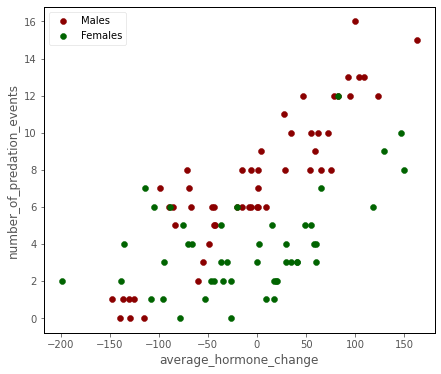

In [23]:
# this code generates the plot below
islands_GLM.pois_group_plot(df)

We'll use `statsmodels` to fit a model with both predictors. The model is: `number_of_predation_events ~ hormone_level_change + biological_sex`. The output of the cell below shows the regression table:

In [24]:
# fit a Poisson regression with statsmodels
pois_mod_2 =  smf.glm('number_of_predation_events ~ hormone_level_change + biological_sex', data =df, family = sm.families.Poisson()).fit() 

# show the regression table
pois_mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                      
======================================================================================
Dep. Variable:     number_of_predation_events   No. Observations:                  100
Model:                                    GLM   Df Residuals:                       97
Model Family:                         Poisson   Df Model:                            2
Link Function:                            log   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -218.13
Date:                        Fri, 01 Jul 2022   Deviance:                       109.59
Time:                                10:40:19   Pearson chi2:                     103.
No. Iterations:                             5                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.3050      0.076     17.249      0.000       1.157       1.453
hormone_level_change     0.0057      0.001     10.135      0.000       0.005       0.007
biological_sex           0.6165      0.090      6.823      0.000       0.439       0.794
========================================================================================
"""

The graph below shows data in 3D dataspace, along with a blue surface showing the Poisson regression model. The regression surface shows the predicted value of the outcome for any pairing of predictor scores:

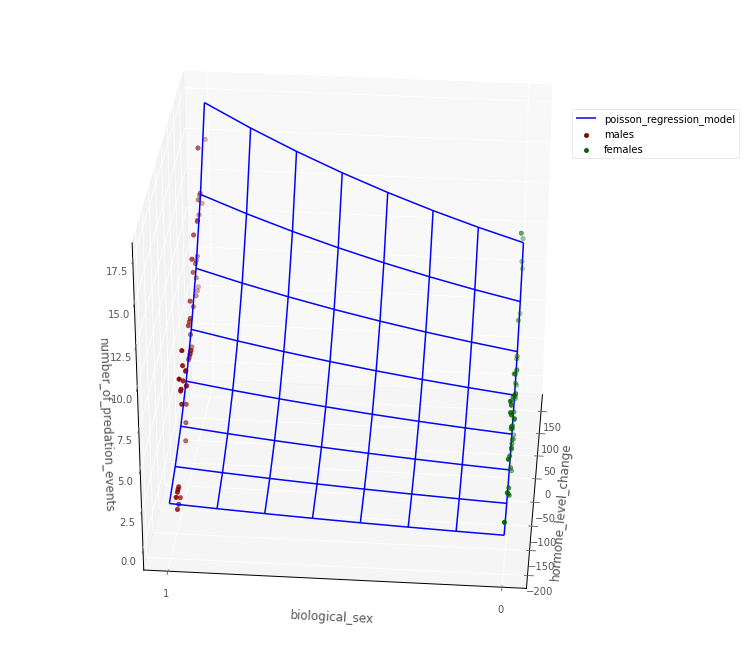

In [25]:
# this code generates the plot below
intercept, hormone_change_slope, biological_sex_slope = pois_mod_2.params[:3]
islands_GLM.three_D_model_plot('hormone_level_change', 'biological_sex', 
                   'number_of_predation_events', intercept, hormone_change_slope, biological_sex_slope,
                  df, 'poisson_regression_model', 'males', 'females')

## Interpretation (multiple predictors)

The intercept, tells us the predicted outcome score (on the log scale) for an observation whose score on all other predictors is 0. The $p$-values for the intercept tells us how (un)likely it would be to obtain an intercpet of the value we obtained, if randomly sampling from a population where the true intercept was 0.

The slope of each predictor tells us the predicted difference in outcome score (on the log scale) when we compare two hypothetical observations which differed *only* by a one unit score in that predictor, controlling for the other variables in the model. The $p$-values for each predictor tell us how (un)likely it would be, under repeated random sampling, to observe a slope of the size we observed if the population slope was zero.

## Statistical interaction in Poisson Regression

The definition of statistical interaction is: the influence of a predictor on the outcome variable depends on the value of some other predictor(s).

If we fit an interaction term in  Poisson regression this allows the Poisson regression surface to 'bend', so that the effect of the predictors is not constant, but depends on the value of the other predictor. This is shown on the graph below:

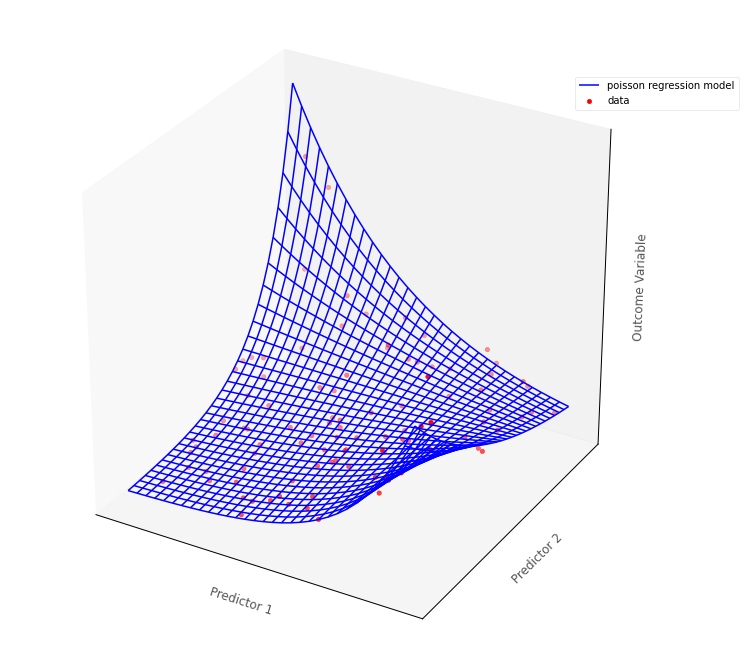

In [26]:
# this code generates the plot below
islands_GLM.three_D_pois_reg_plot(interaction = True)

That's it for Poisson regression (for now). You can visit another page/island via the links below.

## Other Chapters

1. [What are Generalized Linear Models?](1_generalized_linear_models.ipynb)
2. [Linear Regression](2_linear_regression.ipynb)
3. [Poisson Regression](3_poisson_regression.ipynb)
4. [Binary Logistic Regression](4_binary_logistic_regression.ipynb)
5. [Multinomial Logistic Regression](5_multinomial_logistic_regression.ipynb)

***
By [pxr687](99_about_the_author.ipynb) 